## Import Toolkits

In [1]:
#os libs
import os
import shutil
import itertools
from PIL import Image

#Data Handling Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#DeepLearning Tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

#warnings
import warnings
warnings.filterwarnings('ignore')

2024-02-05 14:31:51.606181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 14:31:51.606275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 14:31:51.743315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

In [2]:
tr_data = '/kaggle/input/5-flower-types-classification-dataset/flower_images'

filepath =[]
label = []

folds = os.listdir(tr_data)

for fold in folds:
    f_path = os.path.join(tr_data , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseires = pd.Series(filepath , name= 'filepath')
lseries = pd.Series(label , name = 'label')
tr_df = pd.concat([fseires ,lseries ] , axis = 1)

In [3]:
tr_df

,filepath,label
0,/kaggle/input/5-flower-types-classification-da...,Orchid
1,/kaggle/input/5-flower-types-classification-da...,Orchid
2,/kaggle/input/5-flower-types-classification-da...,Orchid
3,/kaggle/input/5-flower-types-classification-da...,Orchid
4,/kaggle/input/5-flower-types-classification-da...,Orchid
...,...,...
4995,/kaggle/input/5-flower-types-classification-da...,Lilly
4996,/kaggle/input/5-flower-types-classification-da...,Lilly
4997,/kaggle/input/5-flower-types-classification-da...,Lilly
4998,/kaggle/input/5-flower-types-classification-da...,Lilly


## Data Splitting

In [4]:
train , dummy = train_test_split(tr_df ,train_size = 0.8 , shuffle = True ,random_state = 42 )
valid , test = train_test_split(dummy ,test_size= 0.5 , shuffle = True ,random_state = 42)

In [5]:
print(f"The shape of The Train data is: {train.shape}")
print(f"The shape of The Validation data is: {valid.shape}")
print(f"The shape of The Test data is: {test.shape}")

The shape of The Train data is: (4000, 2)
The shape of The Validation data is: (500, 2)
The shape of The Test data is: (500, 2)


## Image Data Generator

In [6]:
img_size = (224,224)
channels = 3
num_batches = 16

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'filepath' , y_col = 'label',target_size=img_size ,
                                       class_mode = 'categorical' ,color_mode= 'rgb',shuffle = True , batch_size= num_batches)
valid_gen = ts_gen.flow_from_dataframe(valid , x_col ='filepath',y_col = 'label', target_size = img_size , 
                                       class_mode= 'categorical', color_mode = 'rgb',shuffle= True, batch_size = num_batches)
test_gen = ts_gen.flow_from_dataframe(test, x_col= 'filepath', y_col= 'label', target_size = img_size,
                                      class_mode= 'categorical',color_mode= 'rgb',shuffle = False , batch_size= num_batches)

Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


## Show sample of Train Data

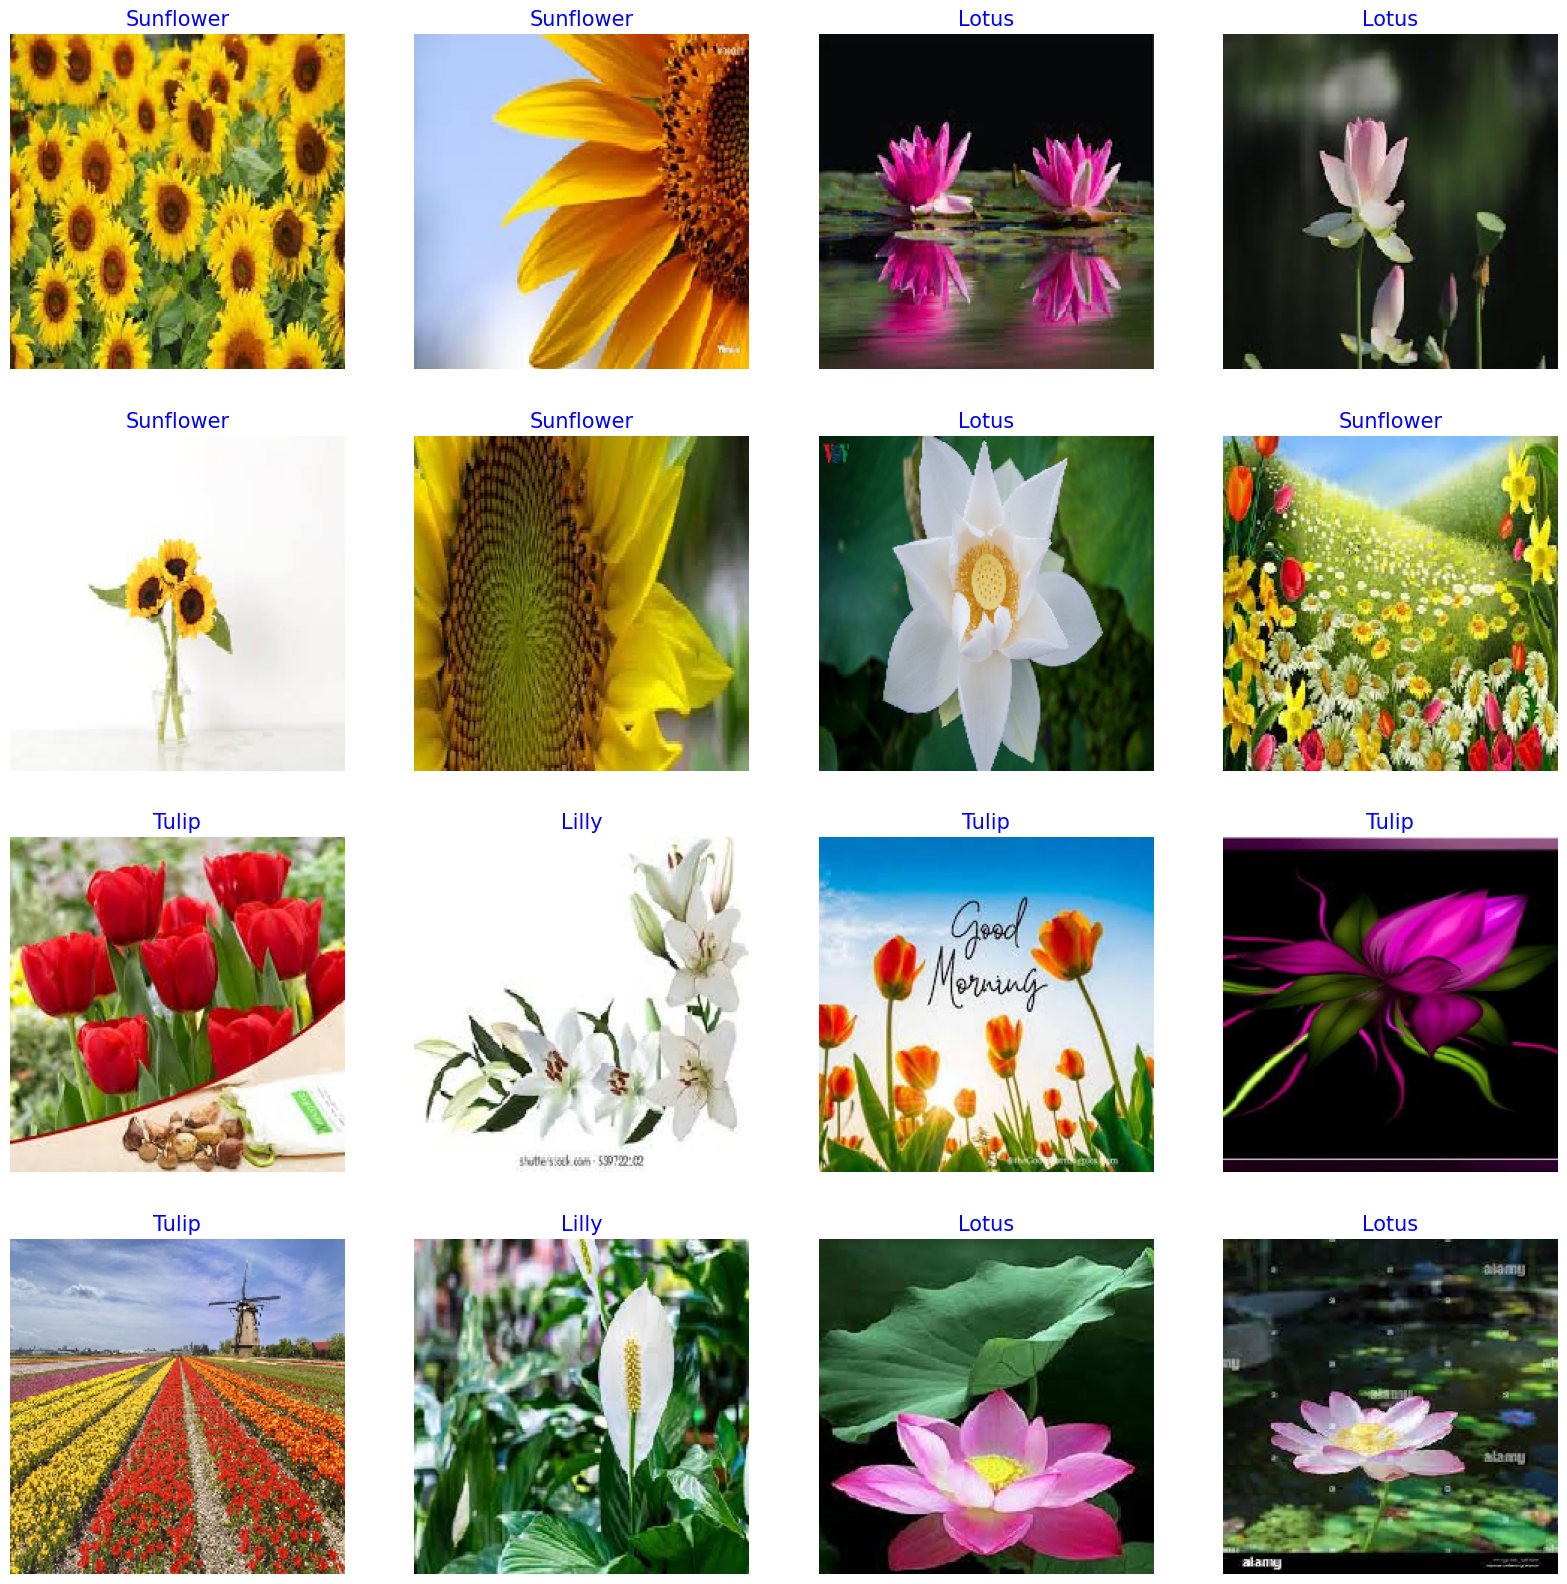

In [7]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 15)
    plt.axis('off')
plt.show();

## Model Structure

In [8]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(classes)

base_model = tf.keras.applications.DenseNet121(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dense(class_count, activation= 'softmax')
])



model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 7305285 (27.87 MB)
Trainable params: 7219589 (27.54 MB)
Non-trainable params: 85696 (334.75 KB)
_________________________________________________________________


## Training

In [9]:
epochs = 15
history = model.fit(train_gen , epochs = epochs , verbose = 1,validation_data= valid_gen, validation_steps=None ,shuffle= False)

Epoch 1/15


I0000 00:00:1707143569.273169     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 116s 208ms/step - loss: 4.3713 - accuracy: 0.8322 - val_loss: 2.8683 - val_accuracy: 0.9020
Epoch 2/15
250/250 [==============================] - 48s 190ms/step - loss: 1.9472 - accuracy: 0.9532 - val_loss: 1.4418 - val_accuracy: 0.9380
Epoch 3/15
250/250 [==============================] - 48s 192ms/step - loss: 1.0579 - accuracy: 0.9600 - val_loss: 0.8249 - val_accuracy: 0.9600
Epoch 4/15
250/250 [==============================] - 48s 192ms/step - loss: 0.6087 - accuracy: 0.9747 - val_loss: 0.5553 - val_accuracy: 0.9460
Epoch 5/15
250/250 [==============================] - 48s 192ms/step - loss: 0.3824 - accuracy: 0.9835 - val_loss: 0.4751 - val_accuracy: 0.9220
Epoch 6/15
250/250 [==============================] - 48s 192ms/step - loss: 0.2936 - accuracy: 0.9797 - val_loss: 0.3304 - val_accuracy: 0.9600
Epoch 7/15
250/250 [==============================] - 48s 192ms/step - loss: 0.2254 - accuracy: 0.9858 - val_loss: 0.3180 - val_accuracy: 0.

## Model Performance

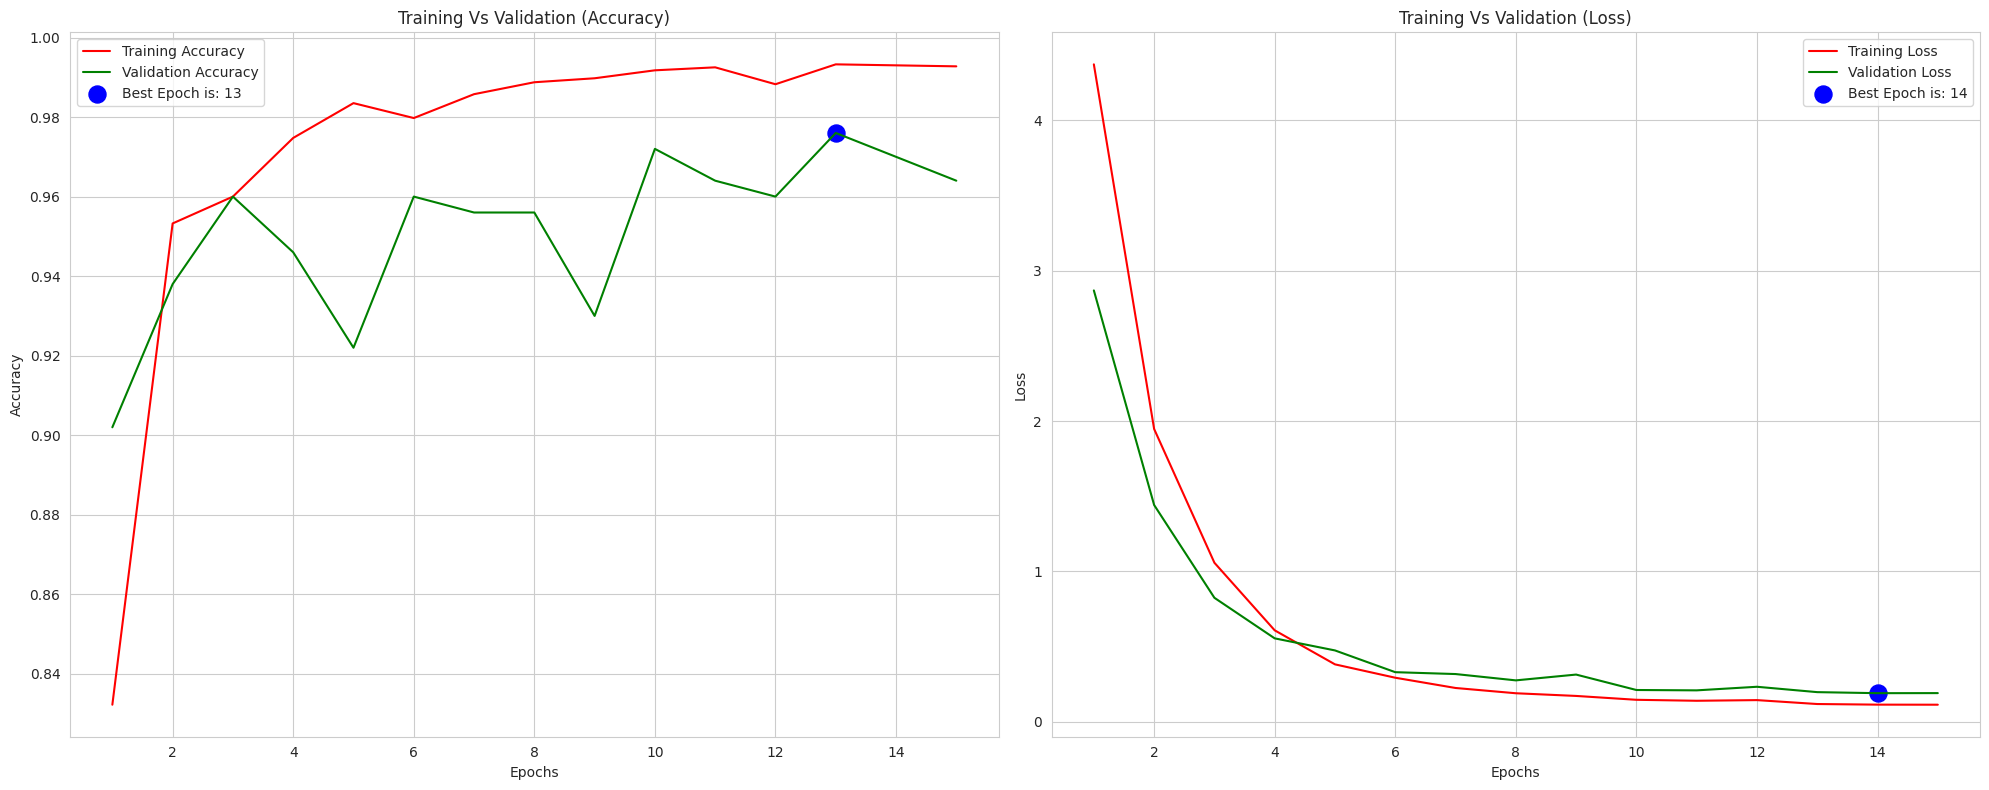

In [10]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_highest = val_acc[index_acc]
val_lowest = val_loss[index_loss]

epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch is: {str(index_loss +1)}'
acc_label = f'Best Epoch is: {str(index_acc + 1)}'

plt.figure(figsize= (20,8))

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(epochs, val_acc , 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue', label= acc_label)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss , 'r' , label= 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label= 'Validation Loss')
plt.scatter(index_loss +1, val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show();

## Model Evaluation

In [11]:
train_score = model.evaluate(train_gen , steps = 16 , verbose= 1)
val_score = model.evaluate(valid_gen , steps= 16, verbose= 1)
test_score = model.evaluate(test_gen , steps =16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", val_score[0])
print("Validation Accuracy: ", val_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 2s 137ms/step - loss: 0.2405 - accuracy: 0.9531
Train Loss:  0.11003689467906952
Train Accuracy:  0.98828125
--------------------
Validation Loss:  0.19097569584846497
Validation Accuracy:  0.95703125
--------------------
Test Loss:  0.24046406149864197
Test Accuracy:  0.953125


## Model Prediction

### 1-Confusion Matrix

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis= 1)

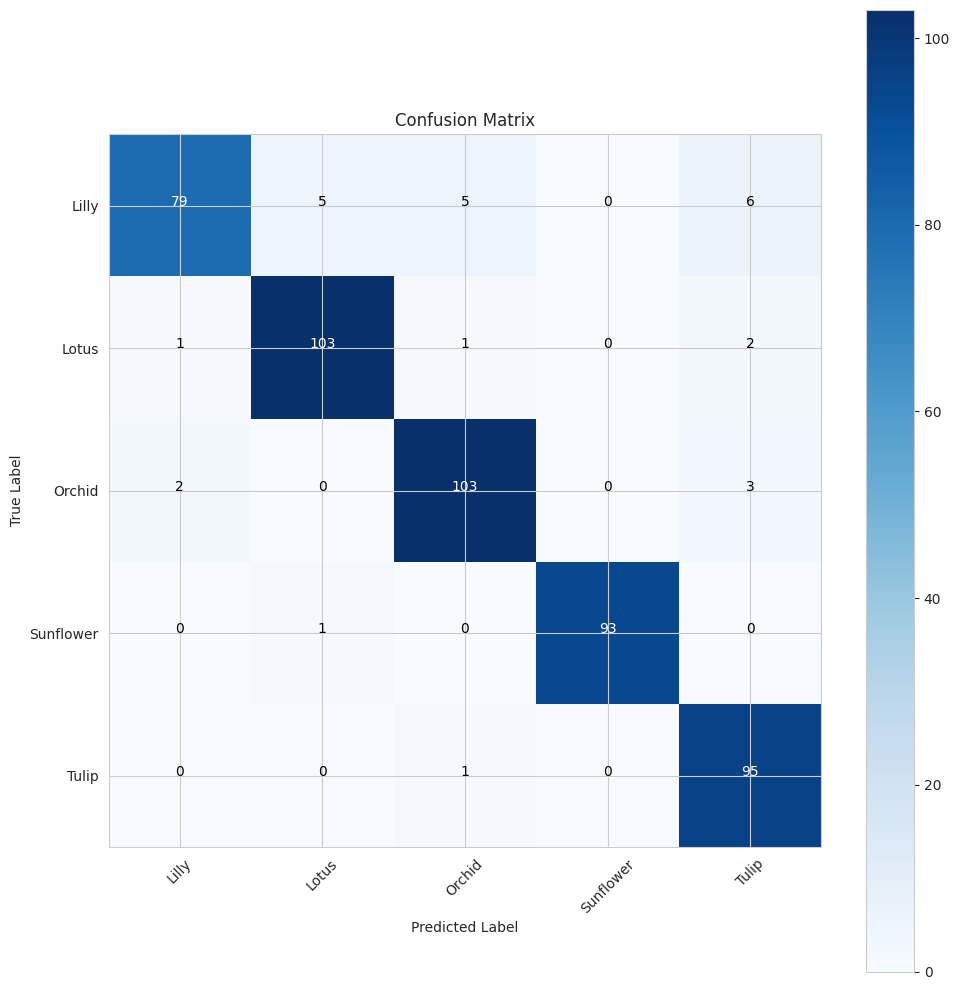

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### 2-Classification Report

In [14]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       Lilly       0.96      0.83      0.89        95
       Lotus       0.94      0.96      0.95       107
      Orchid       0.94      0.95      0.94       108
   Sunflower       1.00      0.99      0.99        94
       Tulip       0.90      0.99      0.94        96

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500

